# Project: Show vs. No-Show Appointment 

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#model">Building Model</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

In this project, I investigated a database of medical appointment records in Brazil to try to predict the liklihood of patients showing up for their scheduled appointment. The database is a part of the original database available online on <a href="https://www.kaggle.com/joniarroba/noshowappointments">Kaggle</a>.
This dataset contains information from 110k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. A number of characteristics about the patient are included in each row.
### Data Dictionary 
<ul>
<li>PatientId : Identification of a patient
<li>AppointmentID : Identification of each appointment 
<li>Gender : Male or Female 
<li>ScheduleDay = The day of the actuall appointment, when they have to visit the doctor.
<li>AppointmentDay = The day someone called or registered the appointment, this is before appointment of course.
<li>Age = How old is the patient
<li>Neighbourhood = Where the appointment takes place
<li>Scholarship = Ture of False (Indicates whether or not the patient is enrolled in Brasilian welfare program)
<li>Hipertension = True or False
<li>Diabetes = True or False
<li>Alcoholism = True or False
<li>Handcap = True or False
<li>SMS_received = 1 or more messages sent to the patient


The questions I am trying to answer here are: 1) how does gender, hadcap, and scholarship relate to the liklihood of patients not showing up for their appoitment. The dependant variable is the no-show column and I chose the independent varibales to be gae, gender, hadcap, and scholarship. 

<a id='wrangling'></a>
## Data Wrangling

### 1. Loading Libraries

In [600]:
import pandas as pd
import numpy as np
import datetime
from time import strftime

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns


### 2. Examine/clean Data

Below, we load the .csv file into the df dataframe. Here we take a look at some general information about the data such as number of rows and columns, number of NaN values in each colum, first couple of rows, data type of each column, and some statistics about each column

In [674]:
# load data, see fisrt couple of rows
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv') 

In [675]:
# see the number of rows and columns 
df.shape

(110527, 14)

In [676]:
# see the first 5 rows
df.head(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [677]:
# statistics for each column
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [683]:
# check how many age < 0
df[df['age']< 0]

,gender,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,show
99832,F,-1,0,0,0,0,0,0,1


In [684]:
# drop rows with age <0 and check succussful drop
df = df[df['age'] >= 0]
df[df['age']< 0]
df=df.reset_index(drop=True)
df.tail(1)

,gender,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,show
110525,F,54,0,0,0,0,0,1,1


In [678]:
# rename columns for easier handeling
df.rename(index=str, columns=lambda x: x.strip().lower().replace('-','_'), inplace=True)
df.head(0)

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show


In [679]:
# add a col that represents no_show numerically
df['show']=pd.Series(np.where(df['no_show'].values == 'Yes', 0, 1),df.index);
df.head(3)

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show,show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,1
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No,1
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No,1


In [680]:
# take a look at unique values 
print('gender: {}'.format(df.gender.unique()))
print('scholarship: {}'.format(df.scholarship.unique()))
print('hipertension: {}'.format(df.hipertension.unique()))
print('scholarship: {}'.format(df.scholarship.unique()))
print('diabetes: {}'.format(df.diabetes.unique()))
print('handcap: {}'.format(df.handcap.unique()))
print('sms_received: {}'.format(df.sms_received.unique()))
print('show: {}'.format(df.show.unique()))

gender: ['F' 'M']
scholarship: [0 1]
hipertension: [1 0]
scholarship: [0 1]
diabetes: [0 1]
handcap: [0 1 2 3 4]
sms_received: [0 1]
show: [1 0]


Except for 'handcap' & 'neighbourhood', all other columns have two values. The max value for Handcap, based on description given for this column, different levels of disabilities are recorded with different values with 4 having 4 disabilities. Next, we take a look at the values for the age column to make sure there are error such as negative values. We also take a look at the percentile for the age column and bin the age into different age groups. 
Based on the information above, we can see that the dependent variable is "no_show" and the independent variables are "gender", "scholarship", "hipertension", "scholarship", "diabetes", "handcap", "sms_received", "show", "neighbourhood".

In [682]:
#drop 'PatientId' and 'AppointmentID' as they wont help us in prediction
df.drop(['patientid', 'appointmentid','scheduledday','appointmentday','no_show','neighbourhood'], axis=1, inplace=True)
#df=df[df.columns[2:]]
df.head(0)

,gender,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,show


In [681]:
# see the data type and numver of NaN values
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110527 entries, 0 to 110526
Data columns (total 15 columns):
patientid         110527 non-null float64
appointmentid     110527 non-null int64
gender            110527 non-null object
scheduledday      110527 non-null object
appointmentday    110527 non-null object
age               110527 non-null int64
neighbourhood     110527 non-null object
scholarship       110527 non-null int64
hipertension      110527 non-null int64
diabetes          110527 non-null int64
alcoholism        110527 non-null int64
handcap           110527 non-null int64
sms_received      110527 non-null int64
no_show           110527 non-null object
show              110527 non-null int32
dtypes: float64(1), int32(1), int64(8), object(5)
memory usage: 13.1+ MB


In [685]:
# bin edges that will be used to "cut" the data into groups
bin_edges = [ 0,19,37 ,55,115 ] 
# labels for the four acidity level groups
bin_names = ['0-18' ,'20-37' ,'38-55' ,'>55' ] # Name each acidity level category
# creates age_levels column
df['age_levels'] = pd.cut(df['age'], bin_edges, labels=bin_names)
# checks for successful creation of this column
df.head()

,gender,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,show,age_levels
0,F,62,0,1,0,0,0,0,1,>55
1,M,56,0,0,0,0,0,0,1,>55
2,F,62,0,0,0,0,0,0,1,>55
3,F,8,0,0,0,0,0,0,1,0-18
4,F,56,0,1,1,0,0,0,1,>55


In [686]:
#drop 'no_show' and 'age' as they wont help us in prediction
df.drop(['age'], axis=1, inplac e=True)
#df=df[df.columns[2:]]
df.head(0)

,gender,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,show,age_levels


<a id='eda'></a>
## Exploratory Data Analysis

### 1. General Ploting and Visualization
Below we take a look at the histogram for all columns with numerical data. 

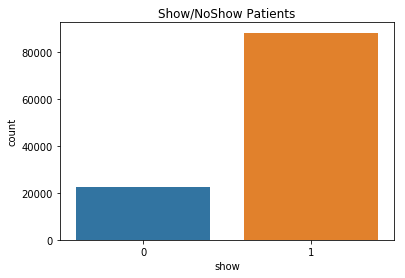

In [687]:
ax = sns.countplot(x=df.show, data=df)
ax.set_title("Show/NoShow Patients")
plt.show()

From information above, about 20% of all patients miss their appointments. In the following section, we try to determine if there is a correlation between no show_up rate and other medical records.

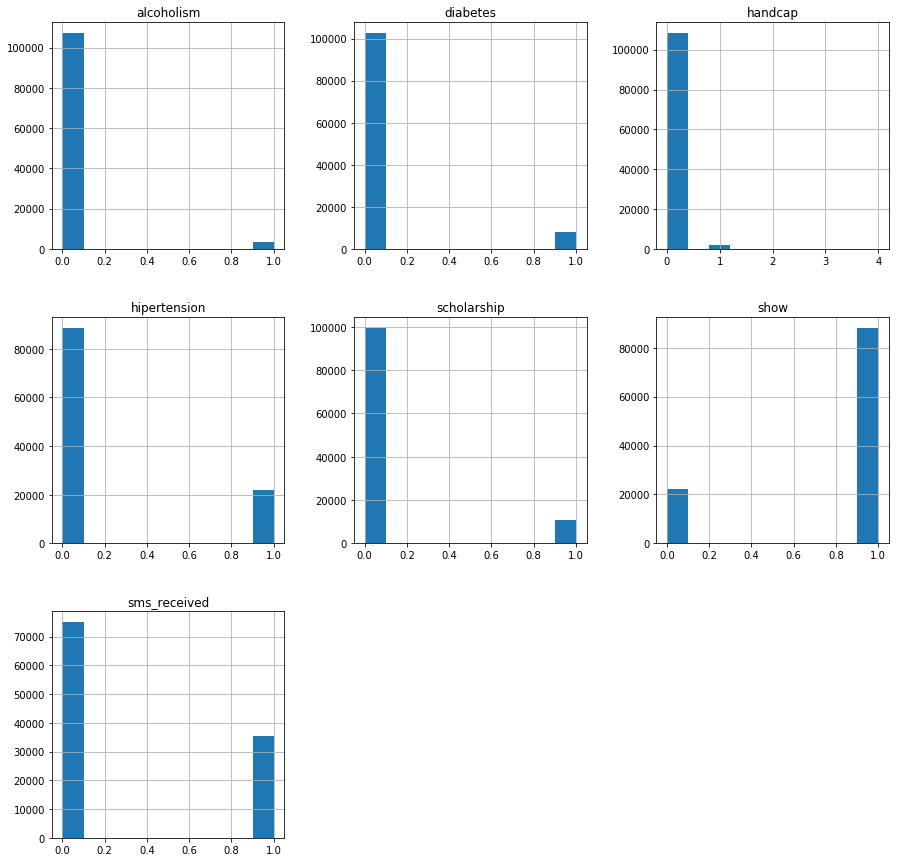

In [689]:
df.hist(figsize = (15,15));

### 2. Gender

Let's first take a look at the number of females and males in our dataset.

In [690]:
# create a mask for show and no-show cases to retreive data easily
showed = df.show ==1
notshowed = df.show ==0

In [692]:
# check to see if gender is associated with showing up to the appointment
df.groupby('gender').count()['diabetes']
# data is skewed so to accurately determine the correlation between show-up, we have to associate the proportion

gender
F    71839
M    38687
Name: diabetes, dtype: int64

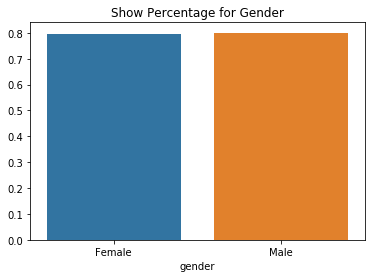

In [863]:
# ratio of show-up based on gender
ratio = df[showed].groupby(['gender']).size()/df.groupby(['gender']).size()
ax = sns.barplot(x=ratio.index, y=ratio)
ax.set_title("Show Percentage for Gender")
x_ticks_labels=['Female','Male']
ax.set_xticklabels(x_ticks_labels)
plt.show()

Basesd on the data above, we see that the number of females are a lot higher than males. We have to take this into account when calculating the percentage of no-show for these groups. Below we find the percentage of no-show for the female and male groups.

In [858]:
# ratio of show-up/no show for females and males
gender_show=df[showed].groupby(['gender']).size() /df.groupby('gender').size()
show_perc=list(gender_show)
no_show_perc =list(1-gender_show)
show_perc

[0.7968512924734475, 0.8003205211052808]

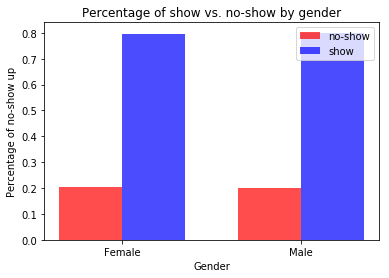

In [866]:
# plot rate of show-up for gender
ind = np.arange(len(show_perc))  # the x locations for the groups
width = 0.35       # the width of the bars
# plot bars
red_bars = plt.bar(ind, no_show_perc, width, color='r', alpha=.7, label='no-show')
white_bars = plt.bar(ind + width, show_perc, width, color='b', alpha=.7, label='show')
# title and labels
plt.ylabel('Percentage of no-show up')
plt.xlabel('Gender')
plt.title('Percentage of show vs. no-show by gender')
locations = ind + width / 2  # xtick locations
labels = ['Female','Male']  # xtick labels
plt.xticks(locations, labels)
# legend
plt.legend();

From the plot above, we can see that female patients booked more appointment compared to male patients. By the first look, we may assume that females have a higher chance of not showing up for their appoitments. However, both groups had very similar values for the the percentage of no-show appointments. Therefore, gender may not have a significant affect on no-show appointments. 

### 3. Age

Here, we take a look at the percentage of no-show appointments among the different age groups that we binned earlier. We would like to know if a certain group have a higher chance of no-show appointment. First, we take a look at the number of patients in each age group. Next, we calcualte the percentage of no-show appointments for each group.

In [696]:
# number of patients in each age group
df.groupby('age_levels').count()['diabetes']

age_levels
0-18     26872
20-37    25705
38-55    26906
>55      27504
Name: diabetes, dtype: int64

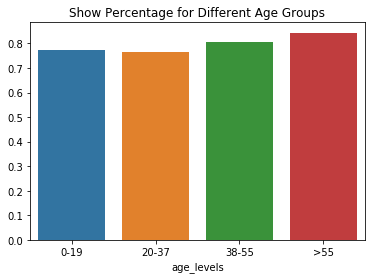

In [845]:
# ratio of show-up based on scholarship
ratio = df[showed].groupby(['age_levels']).size()/df.groupby(['age_levels']).size()
ax = sns.barplot(x=ratio.index, y=ratio)
ax.set_title("Show Percentage for Different Age Groups")
x_ticks_labels=['0-19', '20-37','38-55',">55"]
ax.set_xticklabels(x_ticks_labels)
plt.show()

In [868]:
# ratio of show-up/no show for different age levels
scholarship_show=df[showed].groupby(['age_levels']).size() /df.groupby('age_levels').size()
show_perc=list(scholarship_show)
no_show_perc = list(1-scholarship_show)

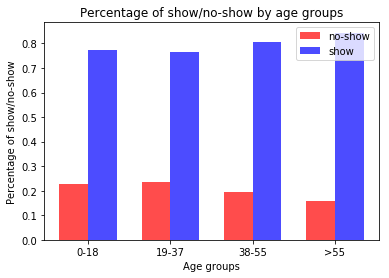

In [869]:
ind = np.arange(len(no_show_perc))  # the x locations for the groups
width = 0.35       # the width of the bars
# plot bars
red_bars = plt.bar(ind, no_show_perc, width, color='r', alpha=.7, label='no-show')
white_bars = plt.bar(ind + width, show_perc, width, color='b', alpha=.7, label='show')
# title and labels
plt.ylabel('Percentage of show/no-show')
plt.xlabel('Age groups')
plt.title('Percentage of show/no-show by age groups')
locations = ind + width / 2  # xtick locations
labels = ['0-18', '19-37', '38-55','>55']# xtick labels
plt.xticks(locations, labels)
# legend
plt.legend();

From the above visualization, we can see that patients with age > 50 had a chance of showing up for the appoitments than other groups. So for a prediction model, age could be a good feature. 

### 4. Scholarship 

Here, we take a look at the percentage of no-show appointments among people who received and not received scholarship. First, we take a look at the number of patients in each group. Next, we calcualte the percentage of no-show appointments for each group.

In [828]:
# number of patients who received scholarship
df.groupby('scholarship').size()

scholarship
0    99665
1    10861
dtype: int64

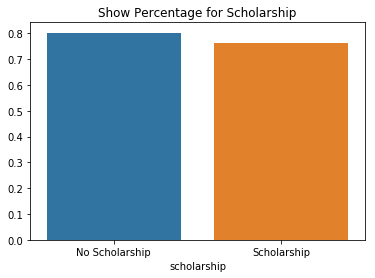

In [705]:
# ratio of show-up based on scholarship
ratio = df[showed].groupby(['scholarship']).size()/df.groupby(['scholarship']).size()
ax = sns.barplot(x=ratio.index, y=ratio)
ax.set_title("Show Percentage for Scholarship")
x_ticks_labels=['No Scholarship', 'Scholarship']
ax.set_xticklabels(x_ticks_labels)
plt.show()

In [840]:
# percentage of no-show/show for scholarship
scholarship_show=df[showed].groupby(['scholarship']).size() /df.groupby('scholarship').size()
show_perc=list(scholarship_show)
no_show_perc = list(1-scholarship_show)

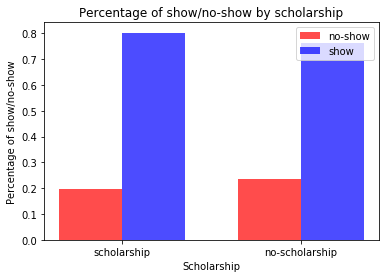

In [842]:
ind = np.arange(len(no_show_perc))  # the x locations for the groups
width = 0.35       # the width of the bars
# plot bars
red_bars = plt.bar(ind, no_show_perc, width, color='r', alpha=.7, label='no-show')
white_bars = plt.bar(ind + width, show_perc, width, color='b', alpha=.7, label='show')
# title and labels
plt.ylabel('Percentage of show/no-show')
plt.xlabel('Scholarship')
plt.title('Percentage of show/no-show by scholarship')
locations = ind + width / 2  # xtick locations
labels = ['scholarship', 'no-scholarship']# xtick labels
plt.xticks(locations, labels)
# legend
plt.legend();

From the above visualization, we can see that about 10% of all patients received scholarship among which about 76% kept their appointments. On the other hand, about 90% of all patients received scholarship among which about 81% kept their appointments. Therefore we can say that there is an association between scholarshio and no-show-up and can help as a feature in a predictive model.

### 5. Handicap

Here, we take a look at the percentage of no-show appointments among people who are handicap. There are four handicap group and as before, we should take into account the number of patients in each handicap group. Next, we calcualte the percentage of no-show appointments for each group.

In [865]:
# number of patients with handicap
df.groupby('handcap').size()

handcap
0    108285
1      2042
2       183
3        13
4         3
dtype: int64

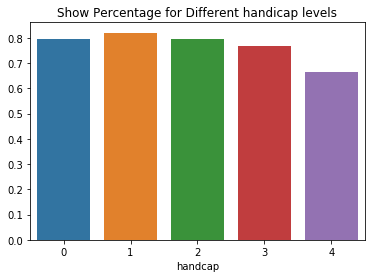

In [870]:
# ratio of show-up based on handicap
ratio = df[showed].groupby(['handcap']).size()/df.groupby(['handcap']).size()
ax = sns.barplot(x=ratio.index, y=ratio)
ax.set_title("Show Percentage for Different handicap levels")
x_ticks_labels=['0', '1','2',"3",'4']
ax.set_xticklabels(x_ticks_labels)
plt.show()

In [871]:
# percentage of no-show/show for scholarship
scholarship_show=df[showed].groupby(['handcap']).size() /df.groupby('handcap').size()
show_perc=list(scholarship_show)
no_show_perc = list(1-scholarship_show)

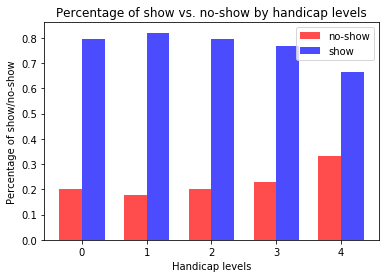

In [872]:
no_show_perc=df[notshowed].groupby(['handcap']).count()['diabetes'] /df.groupby('handcap').count()['diabetes'] 
no_show_perc
ind = np.arange(len(no_show_perc))  # the x locations for the groups
width = 0.35       # the width of the bars
# plot bars
red_bars = plt.bar(ind, no_show_perc, width, color='r', alpha=.7, label='no-show')
white_bars = plt.bar(ind + width, show_perc, width, color='b', alpha=.7, label='show')
# title and labels
plt.ylabel('Percentage of show/no-show')
plt.xlabel('Handicap levels')
plt.title('Percentage of show vs. no-show by handicap levels')
locations = ind + width / 2  # xtick locations
labels = ['0', '1','2','3','4']# xtick labels
plt.xticks(locations, labels)
# legend
plt.legend();

From the above visualization, we can see that there is definitely an association between hanicap and no show-up appointments. The first plot shows that the percentage show-up appointment drops with increasing handicap level. Therefore this feature may help in determining if a patient will or will not show up for their appointement. 

### 6. Alcoholism 

Here, we take a look at the percentage of no-show appointments among people who are alcoholic. There are two groups (alcoholic =1 and non-alcoholic =0) and as before, we should take into account the number of patients in each group. Next, we calcualte the percentage of no-show appointments for each group.

In [737]:
# show-up ratio for patients w/ and w/o alcoholism
show_perc=df[showed].groupby(['alcoholism']).size() /df.groupby('alcoholism').size()
show_perc

alcoholism
0    0.798052
1    0.798512
dtype: float64

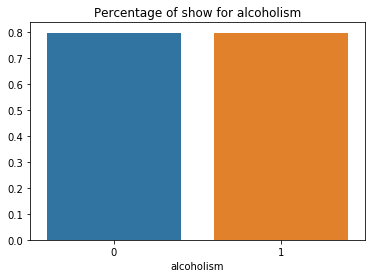

In [738]:
ax = sns.barplot(x=show_perc.index, y=show_perc)
ax.set_title("Percentage of show for alcoholism")
plt.show()

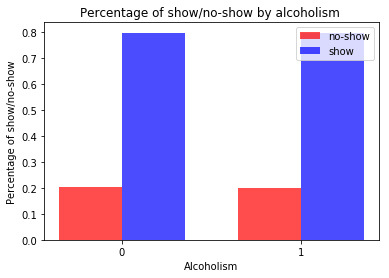

In [876]:
# percentage of no-show/show for alcoholism
scholarship_show=df[showed].groupby(['alcoholism']).size() /df.groupby('alcoholism').size()
show_perc=list(scholarship_show)
no_show_perc = list(1-scholarship_show)
ind = np.arange(len(no_show_perc))  # the x locations for the groups
width = 0.35       # the width of the bars
# plot bars
red_bars = plt.bar(ind, no_show_perc, width, color='r', alpha=.7, label='no-show')
white_bars = plt.bar(ind + width, show_perc, width, color='b', alpha=.7, label='show')
# title and labels
plt.ylabel('Percentage of show/no-show')
plt.xlabel('Alcoholism')
plt.title('Percentage of show/no-show by alcoholism ')
locations = ind + width / 2  # xtick locations
labels = ['0', '1']# xtick labels
plt.xticks(locations, labels)
# legend
plt.legend();

From the above visualization, we can see that the show-up rate for patients with and without alcoholism is about the same. Therefore, this may not be a helpful feature in a predictive model to determine the liklihood of show-up for a patient. 

### 7. Diabetes 

Here, we take a look at the percentage of no-show appointments among people who are alcoholic. There are two groups (alcoholic =1 and non-alcoholic =0) and as before, we should take into account the number of patients in each group. Next, we calcualte the percentage of no-show appointments for each group.

In [877]:
# number of patients w/ diabetes
df.groupby(['diabetes']).size()

diabetes
0    102583
1      7943
dtype: int64

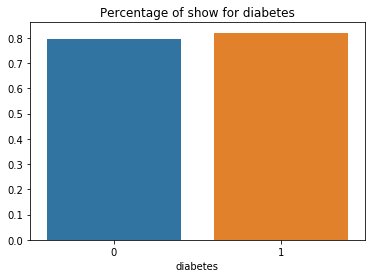

In [878]:
# show-up ratio for patients w/ and w/o diabetes
show_perc=df[showed].groupby(['diabetes']).size() /df.groupby('diabetes').size()
ax = sns.barplot(x=show_perc.index, y=show_perc)
ax.set_title("Percentage of show for diabetes")
plt.show()

In [719]:
df.groupby(['diabetes','show']).count()['gender'] /df.groupby('diabetes').count()['gender'] 

diabetes  show
0         0       0.203630
          1       0.796370
1         0       0.180033
          1       0.819967
Name: gender, dtype: float64

Similar to our analysis before, we can see that about 102583 of all patients did not had diebetes from which about 82% showed up to their appointment and about 7943 had diebetes from which about 80% showed up to their appointment. Therefore we can say that there is an association between diebetes and no-show-up and can help as a feature in a predictive model.

### 8. Sms-Received 

Here, we take a look at the percentage of no-show appointments among people who received sms vs. who didnt. There are two groups (sms-received =1 and not-received =0) and as before, we should take into account the number of patients in each group. Next, we calcualte the percentage of no-show appointments for each group.

In [720]:
# number of patients w/ and w/o sms-received
df.groupby(['sms_received']).count()['diabetes'] 

sms_received
0    75044
1    35482
Name: diabetes, dtype: int64

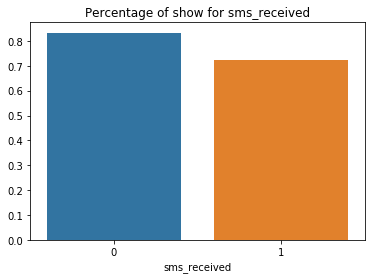

In [879]:
# show-up ratio for patients w/ and w/o diabetes
show_perc=df[showed].groupby(['sms_received']).size() /df.groupby('sms_received').size()
show_perc
ax = sns.barplot(x=show_perc.index, y=show_perc)
ax.set_title("Percentage of show for sms_received")
plt.show()

In [880]:
df.groupby(['sms_received','show']).size() /df.groupby('sms_received').size()

sms_received  show
0             0       0.167035
              1       0.832965
1             0       0.275745
              1       0.724255
dtype: float64

From the above visualization we can see that about 75,000 patients did not receive SMS out of which around 84% showed up to their appointment and about 35,500 patients received SMS around 72% showed up to their appointment. (This is opposite to what one may expect)
There is a distinction between the show-up rate of the two groups therefore, this feature may help us in determining if a patient will turn up for the visit after taking an appointment.

<a id='model'></a>
## Building Model
For the model, we use logistic regression because this is a binary classification. We divide our data set into test and train sets. Using the train set we estimate the coefficients for our parameters and we use the test set to test the performance of our model.

In [764]:
data=df.copy()
data = data[['gender','scholarship','hipertension','diabetes','alcoholism','handcap','sms_received']];
data['gender']=data['gender'].apply(lambda x: 1 if x=='F' else 0);
data.head()

,gender,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received
0,1,0,1,0,0,0,0
1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,1,1,0,0,0


In [765]:
dummy1 = pd.get_dummies(df['age_levels'])
dummy1.head()

,0-18,20-37,38-55,>55
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,1,0,0,0
4,0,0,0,1


In [766]:
# create the training dataset based on the necessary columns
data = data.join(dummy1.iloc[:,1:])
# manually add the intercept
data['intercept'] = 1.0      
data=pd.DataFrame(data)
data.head()

,gender,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,20-37,38-55,>55,intercept
0,1,0,1,0,0,0,0,0,0,1,1.0
1,0,0,0,0,0,0,0,0,0,1,1.0
2,1,0,0,0,0,0,0,0,0,1,1.0
3,1,0,0,0,0,0,0,0,0,0,1.0
4,1,0,1,1,0,0,0,0,0,1,1.0


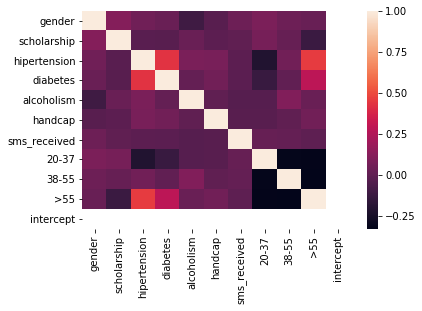

In [767]:
sns.heatmap(data.corr())  

In [768]:
X = data
y = df['show']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: show, dtype: int32

In [769]:
from sklearn.model_selection import StratifiedKFold
from sklearn.cross_validation import StratifiedKFold
kf = StratifiedKFold(y,  n_folds=15,shuffle=True,random_state=45)

for train_index,test_index in kf:
    X_train, X_test = X.loc[train_index],X.loc[test_index]
    Y_train, Y_test = y.loc[train_index],y.loc[test_index]

In [770]:
# number of train set
X_train.shape

(103159, 11)

In [771]:
# number of show/no-show in train set
Y_train.value_counts()

1    82327
0    20832
Name: show, dtype: int64

In [772]:
# number of show/no-show in test set
Y_test.value_counts()

1    5880
0    1487
Name: show, dtype: int64

In [773]:
# create stratified train and test sets
X = data
y = df['show']

import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.492278
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   show   No. Observations:               110526
Model:                          Logit   Df Residuals:                   110515
Method:                           MLE   Df Model:                           10
Date:                Wed, 18 Apr 2018   Pseudo R-squ.:                 0.02146
Time:                        23:02:26   Log-Likelihood:                -54410.
converged:                       True   LL-Null:                       -55603.
                                        LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
gender           0.0014      0.016      0.087      0.931      -0.031       0.034
scholarship     -0.1601

In [774]:
#remove deatures with p value > 0.05
X1 = data[['scholarship','diabetes','alcoholism','sms_received','38-55','>55','intercept']]
X1.head()

,scholarship,diabetes,alcoholism,sms_received,38-55,>55,intercept
0,0,0,0,0,0,1,1.0
1,0,0,0,0,0,1,1.0
2,0,0,0,0,0,1,1.0
3,0,0,0,0,0,0,1.0
4,0,1,0,0,0,1,1.0


In [779]:
logit_model=sm.Logit(y,X1)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.492293
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   show   No. Observations:               110526
Model:                          Logit   Df Residuals:                   110519
Method:                           MLE   Df Model:                            6
Date:                Wed, 18 Apr 2018   Pseudo R-squ.:                 0.02143
Time:                        23:03:34   Log-Likelihood:                -54411.
converged:                       True   LL-Null:                       -55603.
                                        LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
scholarship     -0.1601      0.024     -6.569      0.000      -0.208      -0.112
diabetes        -0.1038

In [780]:
from sklearn.model_selection import StratifiedKFold
from sklearn.cross_validation import StratifiedKFold
kf = StratifiedKFold(y,  n_folds=15,shuffle=True,random_state=45)

for train_index,test_index in kf:
    X_train, X_test = X1.loc[train_index],X1.loc[test_index]
    Y_train, Y_test = y.loc[train_index],y.loc[test_index]

In [810]:
mean_sqr_err1 = ((Y_train-y_train_pred[:,1])**2).sum()/X_train.shape[0]
mean_sqr_err1

0.1574621772796906

In [813]:
mean_sqr_err = ((Y_test-y_test_pred[:,1])**2).sum()/X_test.shape[0]
mean_sqr_err

0.15774432422780205

<a id='conclusions'></a>
## Conclusions

Bases on our analysis, we found that there is some association between patients' likelihood of showing up and these variables:

<ul>
<li>Age
<li>Hypertension
<li>Diabetes
<li>Neighborhood
<li>Handicap type
<li>Scholarship 
<li>SMS_received

There are also two interesting findings:
<ul>
<li>The scholaship program seemed to have a negative correlation with the rate of show-up. In fact the percentage of patients that did show up was higher for the group that did not received scholarship.
<li>Similarly, the patients who received sms had a lower show-up rate compared to thos who did not.  

These findings may not be concretely accuarate since the information about the definitions of each feature was limited. The lack of information about the definition of the values for each feature also restricted the inferences that could be made during the analysis. For example, for the scholarship column, I assumed the value 0 and 1 mean no-scholarhsip vs. scholarship. Similarly for the sms_received, I assumed the value 0 and 1 mean no-sms vs. sms_received. If the definitions of these values are different than our assumptions then the conclutions we made can change. Overall, the lack of information about the columns was a limitation of this study. 